In [1]:
from keras.datasets import fashion_mnist
import wandb
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
# wandb.login()


In [2]:
def relu(x):
    return np.maximum(0,x)

def reluPrime(x):
    return 1*(x>0)

In [3]:
def pre_process(x):
    x=x.reshape(-1,784)
    x=x/255
    return x

In [4]:
class Activation_Functions:
    def __init__(self,function):
        self.function=function
    def getActivations(self,x):
        if self.function=='relu':
            return np.maximum(0,x)
        elif self.function=='sigmoid':
            return 1.0/(1+np.exp(-x))
        elif self.function=='tanh':
            return np.tanh(x)
    def getDerivatives(self,x):
        if self.function=='relu':
             return 1*(x>0)
        elif self.function=='sigmoid':
            return sigmoid(x)*(1-sigmoid(x))
        elif self.function=='tanh':
            return (1 - (np.tanh(x)**2))         

In [5]:
class Optimizers:
    def __init__(self,method):
        self.method=method
    def update(self,obj,lr,momentum=0.9):
        if self.method=='sgd':
            for i in range(len(obj.layers)):
                obj.weights[i]=obj.weights[i]-lr*obj.gradients_w[i]
                obj.biases[i]=obj.biases[i]-lr*obj.gradients_b[i]
        elif self.method=='momentum':
            init=0
            new_gradients=[None]*len(obj.gradients_w)
            for i in range(len(obj.layers)):
                if obj.prev_gradients_w!=None:
                    new_gradients[i]=lr*obj.gradients_w[i]+obj.prev_gradients_w[i]*momentum
                else:
                    new_gradients[i]=lr*obj.gradients_w[i]
                    
                obj.weights[i]=obj.weights[i]-lr*new_gradients[i]
            obj.prev_gradients_w=new_gradients
            
            
            pass
        elif self.method=='rmsprop':
            pass
        elif self.method=='adam':
            pass
        elif self.method=='nadam':
            pass
        elif self.method=='nag':
            pass        

In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def sigmoidPrime(x):
    return sigmoid(x)*(1-sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanhPrime(x):
    return (1 - (np.tanh(x)**2))

In [7]:
def intialize_weights(method,rows,cols):
    if method=='uniform':
        return np.random.rand(rows,cols)
    elif method=='xavier':
        return np.random.randn(rows,cols)*np.sqrt(2/(rows+cols))
    else:
        return np.random.randn(rows,cols)

In [8]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train,x_valid=x_train[:int(len(x_train)*0.8)],x_train[int(len(x_train)*0.8):] #splitting train into train and valid
y_train,y_valid=y_train[:int(len(y_train)*0.8)],y_train[int(len(y_train)*0.8):]

x_train=pre_process(x_train)
x_valid=pre_process(x_valid)
x_test=pre_process(x_test)

In [9]:
def soft_max(x):
    return np.exp(x)/np.sum(np.exp(x),axis=0)
#     min_=np.min(x,axis=0)
#     max_=np.max(x,axis=0)

    x=x-max_
    
#     x=(x-min_)/(max_-min_)
    return np.exp(x)/np.sum(np.exp(x),axis=0)

In [10]:
def soft_max_prime(x):
    return soft_max(x)*(1-soft_max(x))
    

In [11]:
class OneHotEncoder:
    def __init__(self,max_):
        self.max_=max_
    def transform(self,x):
        out=np.zeros((len(x),self.max_))
        out[np.arange(len(x)),x]=1
        return out.T

In [12]:
def cross_entropy_loss(y_pre,y):
#     y_pre[y_pre<1e-15]=1e-15
    loss=-np.sum(y*np.log(y_pre))
    return loss/float(y_pre.shape[1])

In [13]:
def getSig():
    return lambda x:1.0/(1+np.exp(-x))

In [14]:
# best: batch_size=32 sgd sigmoid xavier 87/86

In [15]:
class NN:
    def __init__(self,input_size,layers,active_func='sigmoid',weights_init='xavier'):
        self.input_size=input_size
        self.layers=layers
        self.nlayers=len(layers)
        self.activations=Activation_Functions(active_func)
        self.optimizer=Optimizers('sgd')
        self.weights=[]
        self.weights.append(intialize_weights(weights_init,layers[0],input_size))
        self.deltas=[None]*self.nlayers
        self.gradients_w=[None]*self.nlayers
        self.gradients_b=[None]*self.nlayers
        self.prev_gradients_w=None
        
        
        self.biases=[]
        for i in range(1,len(layers)):
            self.weights.append(intialize_weights(weights_init,layers[i],layers[i-1]))
        for i in range(len(layers)):
            self.biases.append(np.random.randn(layers[i],1))                              
    def forward(self,x):
        layer_outputs=[]
        inter_values=[]
        
        for i in range(len(self.weights)):
            inter_values.append(self.weights[i].dot(x)+self.biases[i])
            if i!= len(self.weights)-1:
                layer_outputs.append(self.activations.getActivations(inter_values[-1]))
                x=layer_outputs[-1]
        layer_outputs.append(soft_max(inter_values[-1]))
        return layer_outputs,inter_values
    def compute_deltas(self,layer_outputs,inter_values,y_one_hot):
#         self.deltas[self.nlayers-1]=(layer_outputs[self.nlayers-1]-y_one_hot)*soft_max_prime(inter_values[self.nlayers-1])
        self.deltas[self.nlayers-1]=(layer_outputs[self.nlayers-1]-y_one_hot)
        
        for i in range(self.nlayers-2,-1,-1):
            self.deltas[i]=np.matmul(self.weights[i+1].T,self.deltas[i+1])*self.activations.getDerivatives(inter_values[i])
        
    def find_gradients(self,x,layer_outs):
        self.gradients_w[0]=np.matmul(self.deltas[0],x.T)/batch_size
        for i in range(1,self.nlayers):
            self.gradients_w[i]=(np.dot(self.deltas[i],layer_outs[i-1].T))/batch_size
        for i in range(self.nlayers):
            self.gradients_b[i]=np.sum(self.deltas[i],keepdims=True)/batch_size
        
            
    def update_weights(self,lr):
        for each in range(self.nlayers):
            self.optimizer.update(self,lr=0.1)
            
    def train(self,x,y,x_valid,y_valid,epochs=1):
        train_losses=[]
        valid_losses=[]
        for epoch in range(epochs):
            self.prev_gradients_w=None
            i=0
            batch_count=0
            loss=0
            while i+batch_size < x.shape[1]:
                batch_count+=1
                x_batch=x[:,i:i+batch_size]
                y_batch=y[:,i:i+batch_size]
                i+=batch_size
                layer_outs,inter_values=self.forward(x_batch)
                loss+=cross_entropy_loss(layer_outs[-1],y_batch)
                self.compute_deltas(layer_outs,inter_values,y_batch)
                self.find_gradients(x_batch,layer_outs)
                self.optimizer.update(self,0.1,0.1)
            train_losses.append(loss/batch_count)
            layer_outs,inter_values=self.forward(x_valid)
            valid_loss=cross_entropy_loss(layer_outs[-1],y_valid)/(y_valid.shape[1])
            valid_losses.append(valid_loss)
            print(f"epoch {epoch+1} : train loss = {train_losses[-1]} valid loss = {valid_loss}")
        return train_losses,valid_losses
    
    def predict_probas(self,x):
        layer_outs,inter_values=self.forward(x)
        return layer_outs[-1]
        

In [16]:
batch_size=32
sample=len(x_train)
x_tr=x_train[:sample]

y_tr=y_train[:sample]

one_hot=OneHotEncoder(10)
one_hot_y_train=one_hot.transform(y_tr)

one_hot_y_valid=one_hot.transform(y_valid)

In [17]:
obj =NN(784,[32,32,32,10],'sigmoid','xavier')
train_losses,valid_losses=obj.train(x_tr.T,one_hot_y_train,x_valid.T,one_hot_y_valid,10)

epoch 1 : train loss = 1.8757664749158278 valid loss = 0.00010994628930967701
epoch 2 : train loss = 1.0350360350015133 valid loss = 6.715222088597284e-05
epoch 3 : train loss = 0.7178534899951687 valid loss = 5.2236781617561086e-05
epoch 4 : train loss = 0.5989641859254835 valid loss = 4.611321226952851e-05
epoch 5 : train loss = 0.5409286837361883 valid loss = 4.268725557177013e-05
epoch 6 : train loss = 0.5016938474621011 valid loss = 4.007199264275371e-05
epoch 7 : train loss = 0.4682492196490171 valid loss = 3.7715188134908755e-05
epoch 8 : train loss = 0.4379786558633515 valid loss = 3.569929682864145e-05
epoch 9 : train loss = 0.41282829193962667 valid loss = 3.410374116287356e-05
epoch 10 : train loss = 0.3935386034351229 valid loss = 3.288457096713116e-05


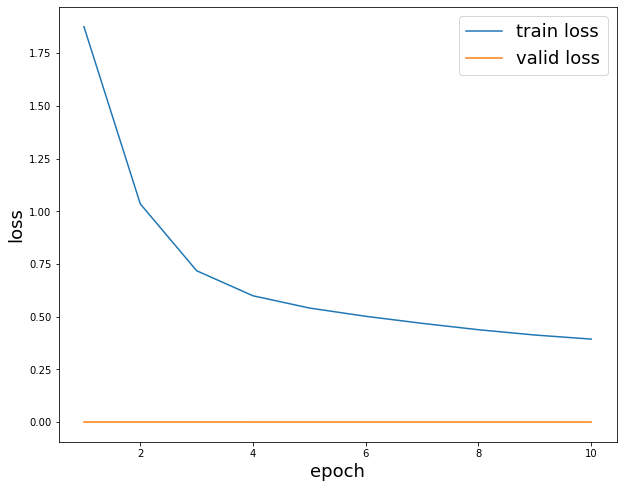

In [18]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(1,len(train_losses)+1),train_losses,label='train loss')
plt.plot(np.arange(1,len(valid_losses)+1),valid_losses,label='valid loss')

plt.xlabel("epoch",fontsize=18)
plt.ylabel("loss",fontsize=18)
plt.legend(fontsize=18)

plt.show()

In [19]:
out=obj.predict_probas(x_tr.T)
pred=np.argmax(out,axis=0)
print(classification_report(pred,y_train.flatten()))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      4813
           1       0.97      0.99      0.98      4698
           2       0.82      0.75      0.79      5187
           3       0.90      0.86      0.88      5035
           4       0.79      0.80      0.79      4716
           5       0.95      0.95      0.95      4823
           6       0.60      0.67      0.64      4355
           7       0.95      0.93      0.94      4957
           8       0.96      0.97      0.97      4751
           9       0.94      0.97      0.95      4665

    accuracy                           0.87     48000
   macro avg       0.87      0.87      0.87     48000
weighted avg       0.87      0.87      0.87     48000



In [20]:
out=obj.predict_probas(x_valid.T)
pred=np.argmax(out,axis=0)
print(classification_report(pred,y_valid.flatten()))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1229
           1       0.96      0.99      0.97      1167
           2       0.80      0.75      0.78      1310
           3       0.90      0.85      0.87      1275
           4       0.76      0.78      0.77      1197
           5       0.93      0.93      0.93      1188
           6       0.59      0.65      0.62      1050
           7       0.94      0.91      0.92      1221
           8       0.96      0.95      0.95      1193
           9       0.93      0.96      0.95      1170

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000



In [21]:
out=obj.predict_probas(x_test.T)
pred=np.argmax(out,axis=0)
print(classification_report(pred,y_test.flatten()))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       988
           1       0.95      0.99      0.97       963
           2       0.79      0.73      0.76      1088
           3       0.88      0.83      0.86      1062
           4       0.75      0.78      0.77       968
           5       0.94      0.94      0.94       992
           6       0.58      0.62      0.60       928
           7       0.95      0.92      0.93      1036
           8       0.95      0.96      0.96       996
           9       0.93      0.95      0.94       979

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [22]:
mapping={
0:'T-shirt/top',
1:'Trouser',
2:'Pullover',
3:'Dress',
4:'Coat',
5:'Sandal',
6:'Shirt',
7:'Sneaker',
8:'Bag',
9:'Ankle boot'} 

labels=list(mapping.values())

In [23]:
def plot_confusion_matrix(target,pred):
    plt.figure(figsize=(14,8))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix(target,pred),cmap=plt.cm.Blues,annot_kws={"fontsize":14},xticklabels=labels,
                yticklabels=labels)
    plt.xlabel('Predcited',fontsize=16)
    plt.ylabel('Actual',fontsize=16)
    plt.title('Confusion matrix (test data)',fontsize=20)
    plt.show()

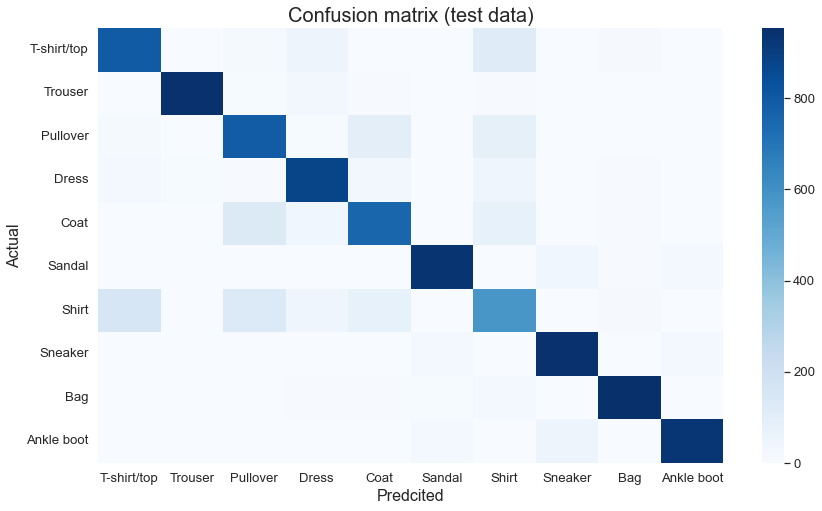

In [24]:
plot_confusion_matrix(y_test,pred)